In [1]:
from fastai.vision.all import *
from fastai.vision.augment import _grid

In [23]:
path = untar_data(URLs.IMAGENETTE_320)

In [102]:
img = Image.open(path.ls()[0].ls()[3].ls()[0])
img = TensorImage(image2tensor(img)[None]/255.)

In [435]:
aug_transforms(max_lighting=.99)[1]

Brightness -- {'max_lighting': 0.99, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: 

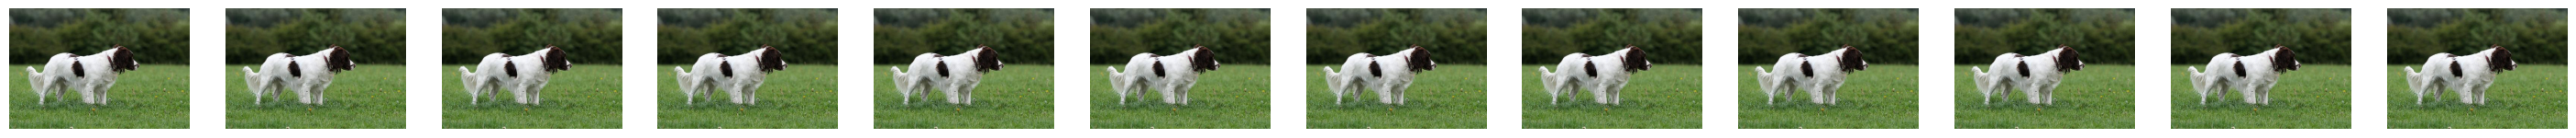

In [434]:
show_images(aug_transforms(max_lighting=.99)[1](img.repeat(12,1,1,1)))

### RandTransform

Notice that p, can be set to control the probability of a transform being applied. 

In [ ]:
class RandTransform(DisplayedTransform):
    "A transform that before_call its state at each `__call__`"
    do,nm,supports,split_idx = True,None,[],0
    def __init__(self, 
        p:float=1., # Probability of applying Transform
        nm:str=None,
        before_call:callable=None, # Optional batchwise preprocessing function
        **kwargs
    ):
        store_attr('p')
        super().__init__(**kwargs)
        self.before_call = ifnone(before_call,self.before_call)

    def before_call(self, 
        b, 
        split_idx:int, # Index of the train/valid dataset
    ):
        "This function can be overridden. Set `self.do` based on `self.p`"
        self.do = self.p==1. or random.random() < self.p

    def __call__(self, 
        b, 
        split_idx:int=None, # Index of the train/valid dataset
        **kwargs
    ):
        self.before_call(b, split_idx=split_idx)
        return super().__call__(b, split_idx=split_idx, **kwargs) if self.do else b

### Affine

Fastai has many affine transforms. These include crop, zoom, flip etc. Lets go through some now. 

In [376]:
xy_grid.shape

torch.Size([1, 320, 480, 2])

In [223]:
def show_grid(xy_grid):
    neutral_dim=torch.zeros_like(xy_grid)[...,0,None]
    normal_grid=torch.cat((xy_grid,neutral_dim),dim=3)
    bad_mask = (normal_grid>1).int() + (normal_grid<-1).int()
    bad_mask=-bad_mask.sum(-1)*10
    normal_grid+=bad_mask[...,None]
    show_images(((normal_grid+1)/2).clip(0,1))

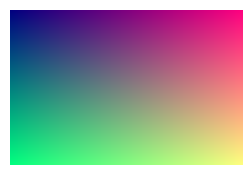

In [224]:
y_coords=torch.linspace(-1,1,img.shape[-2])
x_coords=torch.linspace(-1,1,img.shape[-1])
xy_grid=torch.meshgrid(x_coords, y_coords, indexing='xy')
xy_grid=torch.stack(xy_grid,dim=2)[None]
show_grid(xy_grid)

In [379]:
xy_grid

tensor([[[[-1.0000, -1.0000],
          [-0.9958, -1.0000],
          [-0.9916, -1.0000],
          ...,
          [ 0.9916, -1.0000],
          [ 0.9958, -1.0000],
          [ 1.0000, -1.0000]],

         [[-1.0000, -0.9937],
          [-0.9958, -0.9937],
          [-0.9916, -0.9937],
          ...,
          [ 0.9916, -0.9937],
          [ 0.9958, -0.9937],
          [ 1.0000, -0.9937]],

         [[-1.0000, -0.9875],
          [-0.9958, -0.9875],
          [-0.9916, -0.9875],
          ...,
          [ 0.9916, -0.9875],
          [ 0.9958, -0.9875],
          [ 1.0000, -0.9875]],

         ...,

         [[-1.0000,  0.9875],
          [-0.9958,  0.9875],
          [-0.9916,  0.9875],
          ...,
          [ 0.9916,  0.9875],
          [ 0.9958,  0.9875],
          [ 1.0000,  0.9875]],

         [[-1.0000,  0.9937],
          [-0.9958,  0.9937],
          [-0.9916,  0.9937],
          ...,
          [ 0.9916,  0.9937],
          [ 0.9958,  0.9937],
          [ 1.0000,  0.9937]],



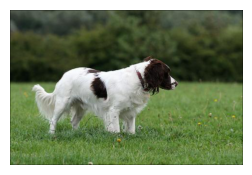

In [380]:
show_images(F.grid_sample(img,xy_grid))

In [226]:
def make_grid(x_coords,y_coords):
    xy_grid=torch.meshgrid(x_coords, y_coords, indexing='xy')
    xy_grid=torch.stack(xy_grid,dim=2)[None]
    return xy_grid

In [ ]:
y_coords=torch.linspace(-1,1,img.shape[-2])
x_coords=torch.linspace(-1,1,img.shape[-1])
make_grid(y_coords)
show_grid(xy_grid)

#### Slide Left

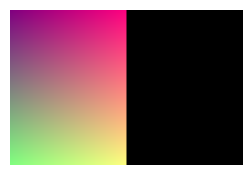

In [227]:
show_grid(make_grid(x_coords+1,y_coords),)

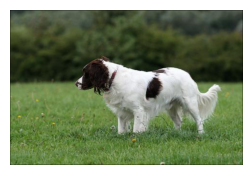

In [385]:
show_images(F.grid_sample(img,make_grid(-1*x_coords,y_coords)))

#### Flip

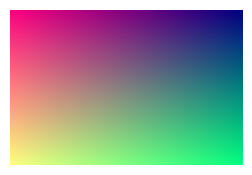

In [386]:
show_grid(make_grid(-1*x_coords,y_coords),)

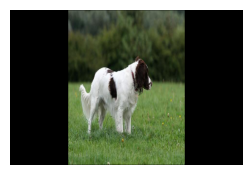

In [391]:
show_images(F.grid_sample(img,make_grid(2.*x_coords,y_coords)))

#### Squish/Resize x dim

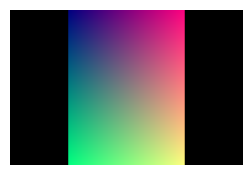

In [232]:
show_grid(make_grid(2*x_coords,y_coords),)

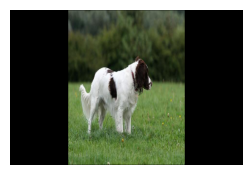

In [233]:
show_images(F.grid_sample(img,make_grid(2*x_coords,y_coords)))

In [394]:
y_coords.shape

torch.Size([320])

In [393]:
x_coords.shape

torch.Size([480])

#### Why can't we use the technique we have used to implement rotate/warp? 

I mostly introduced the previous techniques to make things easy to understand by making x and y indepentdent, but affine transformations can work off of the current x and y values, which takes a bit more code to implement. Lets jump straight into building these like fastai. 

#### F.affine_grid

Affine grids work on much smaller grids. 

In [405]:
translate_grid=torch.tensor([[1.,0,.5],
              [0,1,0]])

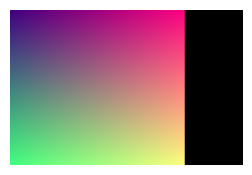

In [406]:
coords_grid=F.affine_grid(translate_grid[None], img.shape)
show_grid(coords_grid)

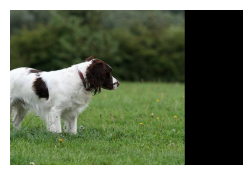

In [407]:
show_images(F.grid_sample(img,coords_grid))

https://en.wikipedia.org/wiki/Affine_transformation

In [402]:
torch.tensor([[1,0,0],
              [0,1,0]])

tensor([[1, 0, 0],
        [0, 1, 0]])

In [404]:
torch.tensor([[1.,0,0],
              [0,1,0]])

tensor([[1., 0., 0.],
        [0., 1., 0.]])

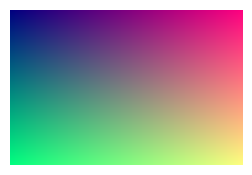

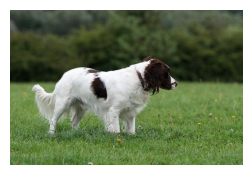

In [400]:
identity_grid=torch.tensor([[1.,0,0],
              [0,1,0]])
coords_grid=F.affine_grid(identity_grid[None], img.shape)
show_grid(coords_grid)
show_images(F.grid_sample(img,coords_grid))

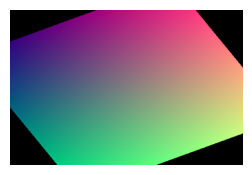

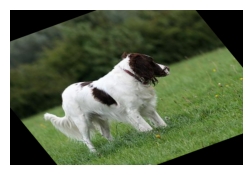

In [409]:
rot_grid=torch.tensor([[math.cos(.5),-math.sin(.5),0],
              [math.sin(.5),math.cos(.5),0]])
coords_grid=F.affine_grid(rot_grid[None], img.shape)
show_grid(coords_grid)
show_images(F.grid_sample(img,coords_grid))

### Rotate

In [410]:
math.cos(.5)

0.8775825618903728

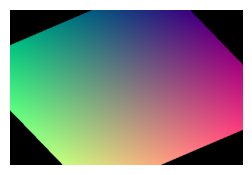

In [411]:
rotate_grid=torch.tensor([[math.cos(1),math.sin(1),0],
              [-math.sin(1),math.cos(1),0]])
coords_grid=F.affine_grid(rotate_grid[None], img.shape)
show_grid(coords_grid)

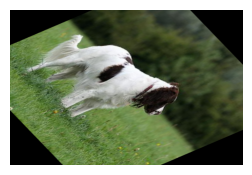

In [412]:
show_images(F.grid_sample(img,coords_grid))

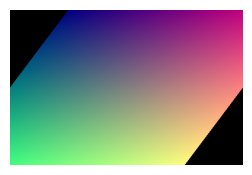

In [413]:
shear_grid=torch.tensor([[1,.5,0],
              [0,1,0]])
coords_grid=F.affine_grid(shear_grid[None], img.shape)
show_grid(coords_grid)

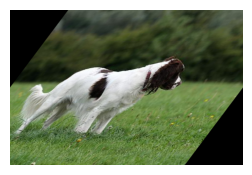

In [414]:
show_images(F.grid_sample(img,coords_grid))

### How would we warp/skew? 

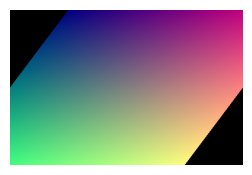

In [265]:
warp_grid=torch.tensor([[1.,.5,0],
              [0,1,0]])
coords_grid=F.affine_grid(warp_grid[None], img.shape)
show_grid(coords_grid)

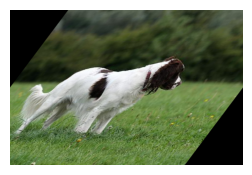

In [266]:
show_images(F.grid_sample(img,coords_grid))

#### Combining affine augmentations

Lets look at the affine grid identity. 

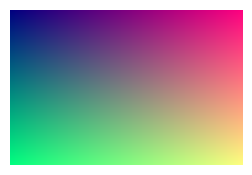

In [267]:
affine_grid=torch.tensor([[1.,0,0],
              [0,1,0]])
coords_grid=F.affine_grid(affine_grid[None], img.shape)
show_grid(coords_grid)

Does this affine grid identity look familiar? Can you think of a way to combine affine transforms? 

#### Implementation

In [285]:
def combine_affines(affines):
    id_row=lambda a:torch.cat((a,torch.tensor([.0,0,1])[None]))
    comb_mat=id_row(affines[0])
    for a in affines:
        comb_mat@=id_row(a)
    return comb_mat[:2]

In [286]:
wrt_grid=combine_affines([warp_grid,rotate_grid,translate_grid])

In [415]:
wrt_grid

tensor([[-0.3012,  1.3818, -0.3012],
        [-0.8415,  0.5403, -0.8415]])

In [291]:
coords_grid=F.affine_grid(wrt_grid[None], img.shape)

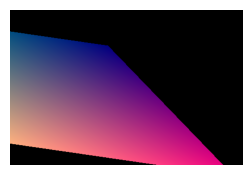

In [292]:
show_grid(coords_grid)

(None, None)

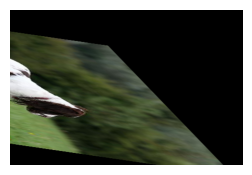

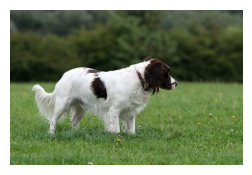

In [294]:
show_images(F.grid_sample(img,coords_grid)),show_images(img)

In [420]:
_BrightnessLogit??

Object `_BrightnessLogit` not found.


### Lighting

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


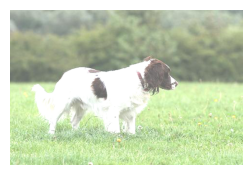

In [425]:
show_images((img+.4))

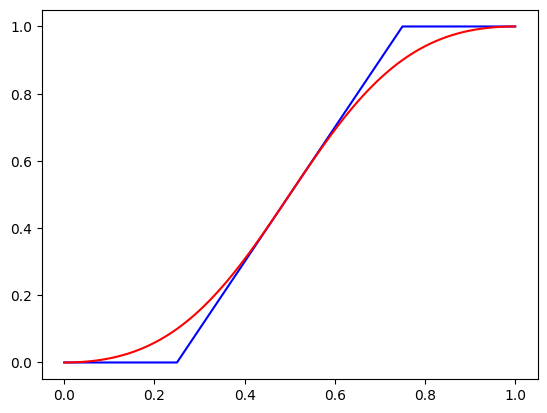

In [302]:
x=TensorImage(torch.tensor([.01* i for i in range(0,101)]))
f_lin= lambda x:(2*(x-0.5)+0.5).clamp(0,1) #blue line
f_log= lambda x:2*x #red line
plt.plot(x,f_lin(x),'b',x,torch.sigmoid(f_log(logit(x))),'r');

What is special about logit in relationship to sigmoid? 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


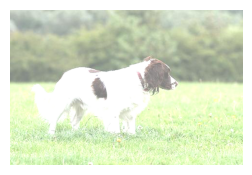

In [363]:
show_images(img+.5)

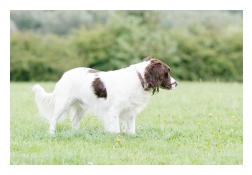

In [426]:
show_images(torch.sigmoid(logit(img)+logit(torch.tensor(.85))))

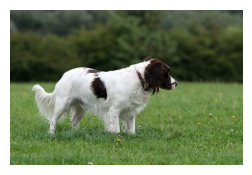

In [427]:
show_images(img)

In [428]:
logit??

#### How to do contrast?

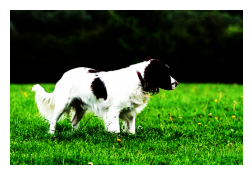

In [365]:
show_images(torch.sigmoid(logit(img)*4))

### Next Section

Open other notebook